Filename: /home/adyachenko/MSX Images/V921 Sco/msxmapA.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      23   (1199, 1199)   float64   
Scale = 6.0000001452000005  arcsec/pix
FOV= 1.9983333816930002 deg
Image data shape: (1199, 1199)
MAX RADIUS = 50.5050492828283 pix
Min: 7.058392839098815e-07
Max: 0.001060228212736547
Mean: 3.6938638370983807e-06
Stdev: 5.0292328959608205e-06
Backgorud outer radius = 62.301622073563976 pixels
 id xcenter ycenter aperture_sum
      pix     pix               
--- ------- ------- ------------
  1   599.5   599.5  0.025637143
 id xcenter ycenter ... aperture_sum_17 aperture_sum_18 aperture_sum_19
      pix     pix   ...                                                
--- ------- ------- ... --------------- --------------- ---------------
  1   599.5   599.5 ...     0.025551796        0.036376     0.061612044
User waveleng = 8.280000000000001 um
Models waveleng = 8.331479235203147 um /index = 97
chi2 mi

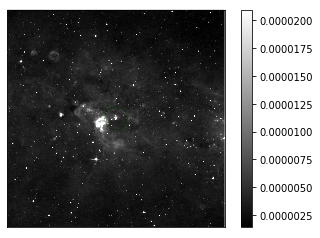

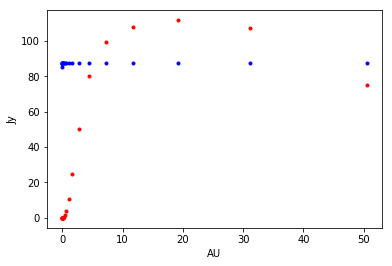

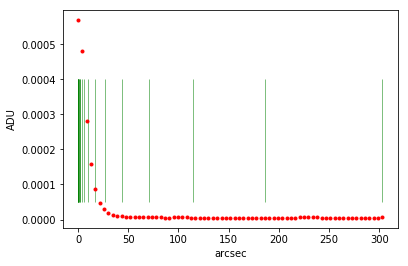

[0.         0.21052632 0.42105263 0.63157895 0.84210526 1.05263158
 1.26315789 1.47368421 1.68421053 1.89473684 2.10526316 2.31578947
 2.52631579 2.73684211 2.94736842 3.15789474 3.36842105 3.57894737
 3.78947368 4.        ]
[  0.           4.32900433   8.65800866  12.98701299  17.31601732
  21.64502165  25.97402597  30.3030303   34.63203463  38.96103896
  43.29004329  47.61904762  51.94805195  56.27705628  60.60606061
  64.93506494  69.26406926  73.59307359  77.92207792  82.25108225
  86.58008658  90.90909091  95.23809524  99.56709957 103.8961039
 108.22510823 112.55411255 116.88311688 121.21212121 125.54112554
 129.87012987 134.1991342  138.52813853 142.85714286 147.18614719
 151.51515152 155.84415584 160.17316017 164.5021645  168.83116883
 173.16017316 177.48917749 181.81818182 186.14718615 190.47619048
 194.80519481 199.13419913 203.46320346 207.79220779 212.12121212
 216.45021645 220.77922078 225.10822511 229.43722944 233.76623377
 238.0952381  242.42424242 246.75324675 251.082251

In [75]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.visualization import ImageNormalize, ZScaleInterval, PercentileInterval
from astropy.wcs import WCS
from astropy.wcs.utils import proj_plane_pixel_scales
from astropy import units as u
from astropy.coordinates import SkyCoord

from photutils import SkyCircularAperture
from photutils import CircularAperture
from photutils import CircularAnnulus
from photutils import aperture_photometry

#distance_range=[1.40745, 1.74476] * u.kpc             # HIP 90617
#arr=['s-pbhmi','s-pbsmi','sp--h-i','s-p-hmi','sp--hmi','sp--s-i','s-p-smi','sp--smi',
#     'spu-hmi','spu-smi','s---s-i','s---smi','s-ubhmi','s-ubsmi','s-u-hmi','s-u-smi','spubsmi','spubhmi'
#dist = 1500 #pc
user_fitsfile ='/home/adyachenko/MSX Images/V921 Sco/msxmapA.fits'
#fits_name = '/home/adyachenko/Downloads/HorseHead.fits'
#models= 'spubsmi'
models= 'sp--h-i'
rob_fitsfile = '/home/adyachenko/Hyperion/%s/flux.fits'%(models)

#distance_range=[1.40745, 1.74476] * u.kpc             # HIP 90617
#arr=['s-pbhmi','s-pbsmi','sp--h-i','s-p-hmi','sp--hmi','sp--s-i','s-p-smi','sp--smi',
    # 'spu-hmi','spu-smi','s---s-i','s---smi','s-ubhmi','s-ubsmi','s-u-hmi','s-u-smi','spubsmi','spubhmi']


obj_name = 'V921Sco'
dist = 1650 #pc
#user_fitsfile = '/home/adyachenko/MSX Images/V921 Sco/msxmapC.fits'



def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx

def rob_fits(user_fitsfile):
    hdul = fits.open(user_fitsfile)
    wavelength = hdul['SPECTRAL_INFO'].data
    wave = wavelength['WAVELENGTH']
    aperture = hdul['APERTURES'].data
    ap = aperture['APERTURE']  
    fnu = hdul['VALUES'].data
    mod_name = hdul['MODEL_NAMES'].data
    name = np.array(mod_name.astype('<U11'))
    return(ap, wave, fnu*(1000/dist)**2/1000) #делим на тысячу чтобы mJy to Jy

def user_fits(rob_fitsfile,ap):
    hdul = fits.open(rob_fitsfile)
    hdul.info()
    image_data = hdul[0].data[::-1,: ] #инвертирует ось y
    wcs = WCS(hdul[0].header)
    waveleng = hdul[0].header['WAVELENG']
    scale = np.mean(proj_plane_pixel_scales(wcs))*3600
    #scale = np.abs(CDELT1)*3600  #arcsec/pix
    FOV = image_data.shape[0]*scale
    hdul.close()
    print("Scale =",scale, " arcsec/pix")
    print("FOV=", FOV/60/60, "deg")
    print('Image data shape:', image_data.shape)
    # AU           | 1.49598e+11 m 
    # pc           | 3.08568e+16 m  
    L = dist * FOV    #мой способ!!
    aupixel = L/image_data.shape[0]   # AU in pixel
    radius = ap/aupixel/2

    radpix = ap/2/dist/scale
    print('MAX RADIUS =', radpix[19], 'pix')
    
    #norm = ImageNormalize(image_data, interval=ZScaleInterval())         # Scale = ZScale
    norm = ImageNormalize(image_data, interval=PercentileInterval(99.5))  # Scale = 99.5%

    ax = plt.subplot(projection=wcs)
    for i in range(0,len(radpix)):
        ax.add_patch(plt.Circle((image_data.shape[0]/2,image_data.shape[0]/2), radpix[i] ,lw = 0.01, color='r', fill=False))
        ax.add_patch(plt.Circle((image_data.shape[0]/2,image_data.shape[0]/2), radpix[19]+ radpix[16] ,lw = 0.01, color='green', fill=False))
    plt.imshow(image_data, cmap='gray',  norm=norm)
    plt.xlabel('Galactic Longitude')
    plt.ylabel('Galactic Latitude')
    plt.colorbar()
    #plt.savefig('HIP90617_A.png', dpi=2000)
    print('Min:', np.min(image_data))
    print('Max:', np.max(image_data))
    print('Mean:', np.mean(image_data))
    print('Stdev:', np.std(image_data))
    return(image_data, radpix, wcs, scale, waveleng,  aupixel )

def photometry_MSX(image_data, radpix, wcs):
    #aperture = CircularAperture((image_data.shape[0]/2,image_data.shape[0]/2), radpix[19])
    position = [image_data.shape[0]/2,image_data.shape[0]/2]
    apertures = [CircularAperture(position, r=r) for r in radpix]
    annulus_aperture = CircularAnnulus(position, r_in=radpix[19], r_out=radpix[19]+radpix[16])
    phot_table = aperture_photometry(image_data, apertures, wcs=wcs)
    bkg_table = aperture_photometry(image_data, annulus_aperture, wcs=wcs)    
    bkg_mean = bkg_table['aperture_sum'] / annulus_aperture.area()
    #sky_aperture = to_sky(apertures,wcs)
    phot_array = np.zeros(20)
    bkg_sum_array = np.zeros(20)
    for i in range(0,20):
        phot_array[i] = phot_table['aperture_sum_' + str(i)][0]
        bkg_sum_array[i] = bkg_mean * apertures[i].area()
        phot_table['aperture_sum_' + str(i)].info.format = '%.8g'  # for consistent table output
    
    final_sum =  phot_array - bkg_sum_array  
    
    y, x = np.indices((image_data[599-50:599+50,599-50:599+50].shape))
    r = np.sqrt((x - 50)**2 + (y - 50)**2)
    r = r.astype(np.int)

    tbin = np.bincount(r.ravel(), image_data[599-50:599+50,599-50:599+50].ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / nr
    
    
    phot_Jy_MSX_A = final_sum* 7.133e12 *scale**2/((180/np.pi)**2*3600**2) # MSX_A W/m^2-sr to Jy *7.133e12*scale**2/((180/np.pi)**2*3600**2)
    phot_Jy_MSX_C = final_sum* 2.863e13 *scale**2/((180/np.pi)**2*3600**2) # MSX_A W/m^2-sr to Jy *2.863e13*scale**2/((180/np.pi)**2*3600**2)
    phot_Jy_MSX_D = final_sum* 3.216e13 *scale**2/((180/np.pi)**2*3600**2) # MSX_A W/m^2-sr to Jy *3.216e13*scale**2/((180/np.pi)**2*3600**2)
    phot_Jy_MSX_E = final_sum* 2.476e13 *scale**2/((180/np.pi)**2*3600**2) # MSX_A W/m^2-sr to Jy *2.476e13*scale**2/((180/np.pi)**2*3600**2)
    
    bkg_table ['aperture_sum'].info.format = '%.8g'  # for consistent table output
    print('Backgorud outer radius =',radpix[19]+radpix[16],'pixels')
    print(bkg_table)
    print(phot_table)
    return(phot_Jy_MSX_A, radialprofile)

def chi2_func(phot_Jy_MSX_A, fnu, wave_index):
    chi2 = np.zeros(fnu.shape[0])
    for i in range(0,fnu.shape[0]):
        chi2[i] = ((phot_Jy_MSX_A - fnu[i,:,wave_index])**2*radpix**2).sum()
        #chi2[i] = ((phot_Jy_MSX_A - fnu[i,:,wave_index])**2).sum()
    
    #idx = [chi2 == min(chi2)]
    #index = np.where(idx)[1]
    index = np.where(chi2 == min(chi2))[0]
    print('chi2 min =',min(chi2))
    print(index)
    plt.figure()
    plt.plot(ap/aupixel/2 , phot_Jy_MSX_A, 'r.') # MSX_A W/m^2-sr to Jy *7.133e12*scale**2/((180/np.pi)**2*3600**2)
    plt.plot(ap/aupixel/2 , fnu[int(index) ,:,wave_index], 'b.')
    plt.xlabel('AU')
    plt.ylabel('Jy')
    plt.show()
    return(chi2)

ap, wave, fnu = rob_fits(rob_fitsfile)
image_data, radpix, wcs, scale, waveleng, aupixel  = user_fits(user_fitsfile,ap)
phot_Jy_MSX_A,radialprofile = photometry_MSX(image_data, radpix, wcs)
rob_wave, wave_index = find_nearest(wave, waveleng*1e6)
print('User waveleng =', waveleng*1e6, 'um')
print('Models waveleng =', rob_wave, 'um', '/index =',wave_index)
chi2 = chi2_func(phot_Jy_MSX_A, fnu, wave_index)

radprof_array= np.zeros(50)
for i in range(0,50):
    radprof_array[i] = image_data[599][599+i] 

fff = np.linspace(0, scale*radpix[19], num=71)
plt.figure()
plt.plot(fff, radialprofile, 'r.') # MSX_A W/m^2-sr to Jy *7.133e12*scale**2/((180/np.pi)**2*3600**2)
#plt.plot(ap, fnu[1000,:,wave_index], 'r.')
for i in range(0,20):
    plt.vlines(scale*radpix[i], 0.00005, 0.0004, lw = 0.5,color='green' )
plt.xlabel('arcsec')
plt.ylabel('ADU')
plt.savefig('radial_prof.png', dpi = 800)
plt.show()

print(np.log10(radpix/radpix[0]))
print(fff)

In [74]:
ap

array([1.00000000e+02, 1.62377674e+02, 2.63665090e+02, 4.28133240e+02,
       6.95192796e+02, 1.12883789e+03, 1.83298071e+03, 2.97635144e+03,
       4.83293024e+03, 7.84759970e+03, 1.27427499e+04, 2.06913808e+04,
       3.35981829e+04, 5.45559478e+04, 8.85866790e+04, 1.43844989e+05,
       2.33572147e+05, 3.79269019e+05, 6.15848211e+05, 1.00000000e+06])

In [ ]:
import numpy as np

def radial_profile(data, center):
    y, x = np.indices((data.shape))
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    r = r.astype(np.int)

    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / nr
    

In [2]:
idx = [chi2 == 2163.5229333817797]
idx2 = np.where(idx)[1]
print(idx2)
plt.figure()
plt.plot(ap, phot_Jy_MSX_A, 'r.') # MSX_A W/m^2-sr to Jy *7.133e12*scale**2/((180/np.pi)**2*3600**2)
plt.plot(ap, fnu[int(idx2) ,:,wave_index], 'b.')
plt.xlabel('AU')
plt.ylabel('Jy')
plt.show()

NameError: name 'chi2' is not defined

In [99]:
import photutils
position = [image_data.shape[0]/2,image_data.shape[0]/2]
aperture = [SkyCircularAperture(position, r=r) for r in radpix]
annulus_aperture = CircularAnnulus(position, r_in=radpix[19], r_out=radpix[19]+radpix[16])
annulus_aperture.area()
hel(aperture[0])

TypeError: positions must be a SkyCoord object.

In [118]:
fnu[62855,:,wave_index]

array([8.3511723e-06, 3.1181524e-05, 1.1784705e-04, 3.4523857e-04,
       8.6038950e-04, 2.5837237e-03, 6.9889990e-03, 1.9933635e-02,
       6.2739186e-02, 2.3103383e-01, 1.7759768e+00, 1.2977672e+01,
       3.3455162e+01, 5.4947781e+01, 5.9258797e+01, 7.4100868e+01,
       7.7357864e+01, 7.7358055e+01, 7.7358055e+01, 7.7358055e+01],
      dtype=float32)

In [85]:
np.nanargmin(chi2)


256309

In [47]:
 bkg_sum_array

array([1.06612071e-10, 2.81098814e-10, 7.41159440e-10, 1.95417870e-09,
       5.15248704e-09, 1.35853096e-08, 3.58197187e-08, 9.44440935e-08,
       2.49016104e-07, 6.56568535e-07, 1.73114202e-06, 4.56441715e-06,
       1.20347746e-05, 3.17314992e-05, 8.36648860e-05, 2.20595097e-04,
       5.81632260e-04, 1.53356122e-03, 4.04346557e-03, 1.06612071e-02])

In [27]:
annulus_aperture.area()

8.304370987426017

In [92]:
scale**2/((180/np.pi)**2*3600**2)

8.461595403616441e-10

In [34]:
phot_table = aperture_photometry(image_data, aperture)
phot_table['aperture_sum'].info.format = '%.8g'  # for consistent table output
print(phot_table)

 id xcenter ycenter aperture_sum
      pix     pix               
--- ------- ------- ------------
  1   599.5   599.5  0.023897853


In [12]:
phot_table

id,xcenter,ycenter,aperture_sum_0,aperture_sum_1,aperture_sum_2,aperture_sum_3,aperture_sum_4,aperture_sum_5,aperture_sum_6,aperture_sum_7,aperture_sum_8,aperture_sum_9,aperture_sum_10,aperture_sum_11,aperture_sum_12,aperture_sum_13,aperture_sum_14,aperture_sum_15,aperture_sum_16,aperture_sum_17,aperture_sum_18,aperture_sum_19
,pix,pix,,,,,,,,,,,,,,,,,,,,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,599.5,599.5,4.4389599e-08,1.1703988e-07,3.085933e-07,8.1365279e-07,2.1453184e-06,5.6564556e-06,1.4914099e-05,3.9323272e-05,0.00010368174,0.00027337255,0.00072078799,0.0018532493,0.0042336112,0.0082257978,0.010941277,0.011805939,0.012506054,0.013838021,0.016802473,0.023897853


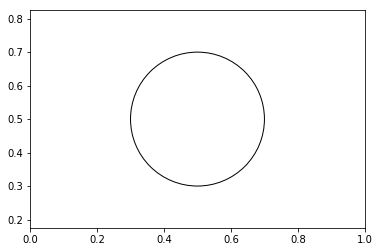

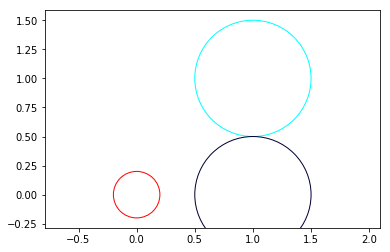

In [14]:
import matplotlib.pyplot as plt

circle2 = plt.Circle((0.5, 0.5), 0.2,  fill=False)
fig, ax = plt.subplots() # note we must use plt.subplots, not plt.subplot
# (or if you have an existing figure)
# fig = plt.gcf()
# ax = fig.gca()
ax.set_aspect('equal', adjustable='datalim')
ax.add_artist(circle2)

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.add_patch(plt.Circle((0, 0), 0.2, color='r', fill=False))
ax.add_patch(plt.Circle((1, 1), 0.5, color='#00ffff', fill=False))
ax.add_artist(plt.Circle((1, 0), 0.5, color='#000033', fill=False))
#Use adjustable='box-forced' to make the plot area square-shaped as well.
ax.set_aspect('equal', adjustable='datalim')
ax.plot()   #Causes an autoscale update.
plt.show()


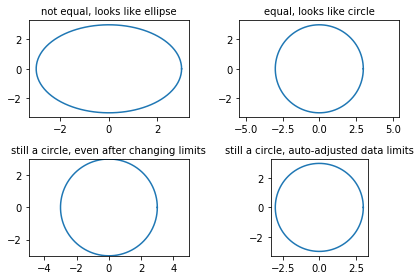

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Plot circle of radius 3.

an = np.linspace(0, 2 * np.pi, 100)
fig, axs = plt.subplots(2, 2)

axs[0, 0].plot(3 * np.cos(an), 3 * np.sin(an))
axs[0, 0].set_title('not equal, looks like ellipse', fontsize=10)

axs[0, 1].plot(3 * np.cos(an), 3 * np.sin(an))
axs[0, 1].axis('equal')
axs[0, 1].set_title('equal, looks like circle', fontsize=10)

axs[1, 0].plot(3 * np.cos(an), 3 * np.sin(an))
axs[1, 0].axis('equal')
axs[1, 0].set(xlim=(-3, 3), ylim=(-3, 3))
axs[1, 0].set_title('still a circle, even after changing limits', fontsize=10)

axs[1, 1].plot(3 * np.cos(an), 3 * np.sin(an))
axs[1, 1].set_aspect('equal', 'box')
axs[1, 1].set_title('still a circle, auto-adjusted data limits', fontsize=10)

fig.tight_layout()

plt.show()